In [ ]:
from google.colab import drive

drive.mount('/content/drive')
FOLDERNAME = "Stanford Summer Session/SOC 128D"

#Packages for working with data
# !pip install "modin[dask]"
# import modin.pandas as pd
import pandas as pd
import matplotlib.pyplot as mplt
import seaborn as sb
import plotnine as pn
import numpy as np

mplt.style.use("ggplot")

Mounted at /content/drive


1. Run a topic model with 4 topics on the “guardian_co_river.csv” dataset.

In [ ]:
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
import regex as re
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

with open("stopwords_extra.json", "r") as file: stopwords_extra = set(json.load(file))
stopwords_nltk = set(stopwords.words('english'))
punctuation += "–—―‗‘’‚‛“”„†‡•…‰′″‹›‼‾⁄⁊"
stopwords_punct = set(punctuation)
combined_stoplist = list(set.union(stopwords_extra, stopwords_nltk, stopwords_punct))

# I used the dataset with 18548 articles, for practice working with bigger datasets
df = pd.read_csv(f"drive/My Drive/{FOLDERNAME}/data/guardian_co_river.csv").dropna(subset=["body_text"])
# Unicode Categories C (Oontrol), M (Mark), P (Punctuation), S (Symbol), Z (Separator) + emojis
df["body_text"] = df["body_text"].apply(lambda x: re.compile(r'[\p{C}|\p{M}|\p{P}|\p{S}|\p{Z}]+', re.UNICODE).sub(" ", x).strip())



# In doing this, token_pattern parameter in CountVectorizer won't work, so just add any patterns here
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, docs):
        return [self.wnl.lemmatize(word, pos=get_POS_tags(tag)) for word, tag in pos_tag(word_tokenize(docs)) if not re.search("\d+", word)]
# Lemmatization
def get_POS_tags(pos_tag):
  POS_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
  try:
    # Getting first 2 letters of pos_tag
    return POS_tag[pos_tag[:2]]
  except:
    # Fallback to noun (Default)
    return 'n'
# This python library automatically integrates anti-joining stopwords and takes in corpus as list of texts, converting into list of words via word_tokenize, to output DTM. Thus unnest_tokens not used
tf_vectorizer = CountVectorizer(stop_words=combined_stoplist, tokenizer=LemmaTokenizer(), strip_accents=None)
# tf is in the form (doc, word): freq
tf = tf_vectorizer.fit_transform(df["body_text"])

print(f"No. of words per topic: {len(tf_vectorizer.get_feature_names_out())}")
pd.DataFrame({"word": tf_vectorizer.get_feature_names_out()})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-15-ee2e12927e35>:22: DtypeWarning: Columns (19,29,34,37,40,42,43,44,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent 

No. of words per topic: 157463


,word
0,aa
1,aaa
2,aaaaaaaaaaaaa
3,aaaaaaaaaaarghhhheeeeiiiiiiiiuhhhhhhhhhhhbyyyy...
4,aaaaaargh
...,...
157458,ﬁction
157459,ﬁnal
157460,ﬁnding
157461,ﬁre


In [ ]:
def get_model_topics(model, vectorizer, topics, n_top_words=10, detailed=False):
  word_dict = {}
  words = vectorizer.get_feature_names_out()
  if detailed:
    for topic_i, topic_freq in enumerate(model.components_):
      # Sorting indexes of words by top frequent topics
      top_freq_words_i = topic_freq.argsort()[:-n_top_words - 1:-1]
      # {topic: [(word, word_p), ...]}
      word_dict[topics[topic_i]] = [(words[i], topic_freq[i]/len(topic_freq)) for i in top_freq_words_i]
    return pd.DataFrame([(topic, word, freq) for topic, words in word_dict.items() for word, freq in words], columns=["Topic", "Word", "Probability"])

  else:
    for topic_i, topic_freq in enumerate(model.components_):
      top_freq_words_i = topic_freq.argsort()[:-n_top_words - 1:-1]
      # {topic: [word, ...]}
      word_dict[topics[topic_i]] = [words[i] for i in top_freq_words_i]
    return pd.DataFrame(word_dict)


from sklearn.decomposition import LatentDirichletAllocation as LDA
lda4 = LDA(n_components=4, random_state=1)
# probability of each (4) topic per (17982) document
topic_per_document = lda4.fit_transform(tf)
# Frequency of each (157463) word-term per (4) topic
word_per_topic = lda4.components_

# Log Likelihood: ✅Less negative
print("Log Likelihood: ", lda4.score(tf))

# Perplexity: exp(-1 * log likelihood), ✅Lower
print("Perplexity: ", lda4.perplexity(tf))

topics_words_df4 = get_model_topics(lda4, tf_vectorizer, ["Topic 1", "Topic 2", "Topic 3", "Topic 4"])
topics_words_df4

Log Likelihood:  -86926244.37087119
Perplexity:  5463.206371294159


,Topic 1,Topic 2,Topic 3,Topic 4
0,people,trump,year,year
1,water,state,make,day
2,year,republican,people,city
3,government,president,time,river
4,state,win,work,time
5,report,vote,life,world
6,country,make,river,park
7,river,year,find,make
8,case,time,child,run
9,make,election,film,back


2. Plot the top words for each topic, similar to what is done in section 5.2. What would you label these topics?

In [ ]:
topics_words_df4 = get_model_topics(lda4, tf_vectorizer, ["Topic 1", "Topic 2", "Topic 3", "Topic 4"], detailed=True)
topics_words_df4

,Topic,Word,Probability
0,Topic 1,people,0.150188
1,Topic 1,water,0.139437
2,Topic 1,year,0.135564
3,Topic 1,government,0.113529
4,Topic 1,state,0.104199
5,Topic 1,report,0.096412
6,Topic 1,country,0.082658
7,Topic 1,river,0.081916
8,Topic 1,case,0.074222
9,Topic 1,make,0.070491


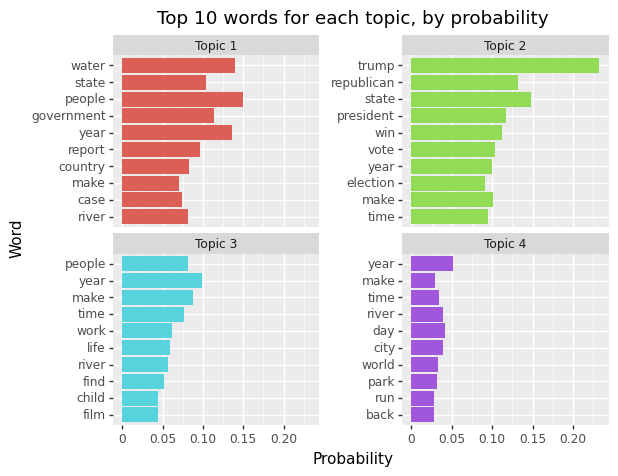

In [ ]:
# I've tried searching but I'm not sure why the sorting is not working, df is sorted, and x is also reordered within
plot = (pn.ggplot(topics_words_df4, pn.aes(x='reorder(Word, Probability)', y='Probability', fill='Topic')) +
        pn.geom_col(show_legend=False) +
        pn.coord_flip() +
        pn.facet_wrap('Topic', scales = "free_y") +
        pn.theme(subplots_adjust={'wspace': 0.4}) +
        pn.labs(title="Top 10 words for each topic, by probability", x="Word", y="Probability")
        )

print(plot)

They are words are not very distinct, due to choice of number of topics, but I would label them

Topic 1: Government

Topic 2: Politics

Topic 3: Work

Topic 4: Time

3. Try running the LDA again, this time with a different number of topics. Does the new topic model make more or less sense to you?



In [ ]:
from sklearn.model_selection import GridSearchCV

lda = LDA()
model = GridSearchCV(lda, param_grid={'n_components': [2, 4, 6, 8, 10]})
model.fit(tf)

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", model.best_estimator_.perplexity(tf))

Best Model's Params:  {'n_components': 2}
Best Log Likelihood Score:  -20246738.786500275
Model Perplexity:  9943.179337936572


In [ ]:
lda2 = LDA(n_components=2, random_state=1)
_ = lda2.fit_transform(tf)

topics_words_df2 = get_model_topics(lda2, tf_vectorizer, ["Topic 1", "Topic 2"])
topics_words_df2

,Topic 1,Topic 2
0,year,trump
1,people,state
2,river,year
3,water,make
4,make,time
5,time,republican
6,day,win
7,work,president
8,government,people
9,world,vote


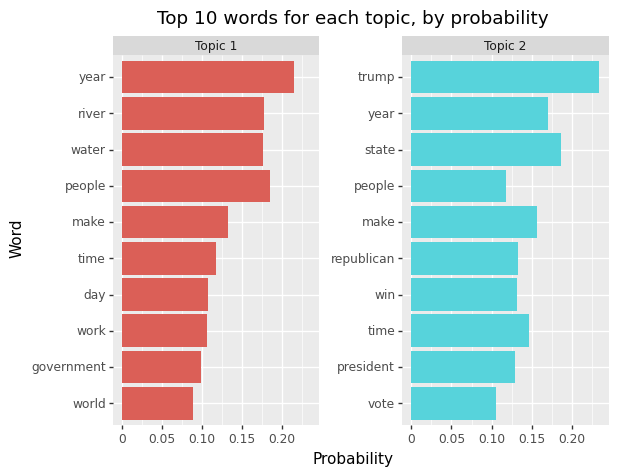

In [ ]:
topics_words_df2 = get_model_topics(lda2, tf_vectorizer, ["Topic 1", "Topic 2"], detailed=True)
plot = (pn.ggplot(topics_words_df2, pn.aes(x='reorder(Word, Probability)', y='Probability', fill='Topic')) +
        pn.geom_col(show_legend=False) +
        pn.coord_flip() +
        pn.facet_wrap('Topic', scales = "free_y") +
        pn.theme(subplots_adjust={'wspace': 0.4}) +
        pn.labs(title="Top 10 words for each topic, by probability", x="Word", y="Probability")
        )

print(plot)

My intuition was 2 topics (based on the in-class materials), but I also wanted to test the optimal number using the GridSearch, which confirmed my intuition.

As evident, 2 topics summarises all the documents more clearly and sensibly, with Topic 1 being about rivers and Topic 2 being more political

4. Using whichever topic model made the most sense to you, create a dataset similar to co_documents in section 5.3. Choose two articles to examine in more detail. Discuss the topic probabilities.



In [ ]:
def get_model_docs(model, dtm, detailed=False):
    topic_dict = {}
    doc_topic = model.transform(dtm)
    if detailed:
      for doc_i, topic_probs_of_doc in enumerate(doc_topic):
        num_topics = doc_topic.shape[1]
        # Sorting topics by top probabilities
        top_probable_topics = topic_probs_of_doc.argsort()[:-num_topics - 1:-1]
        topic_dict[f"Doc {doc_i}"] = [(topic+1, topic_probs_of_doc[topic]) for topic in top_probable_topics]
      df = pd.DataFrame([(doc, topic, prob) for doc, topics_probs in topic_dict.items() for topic, prob in topics_probs], columns=["Document", "Topic", "Probability"])
      # Chaining doesn't work for some reason
      df['Dominant_topic'] = df[df.index % num_topics == 0]["Topic"]
      df['Dominant_topic'] = df['Dominant_topic'].fillna(method='ffill')
      df['Dominant_topic'] = df['Dominant_topic'].astype(int)
      return df

    else:
      for doc_i, topic_probs_of_doc in enumerate(doc_topic):
        num_topics = doc_topic.shape[1]
        top_probable_topics = topic_probs_of_doc.argsort()[:-num_topics - 1:-1]
        topic_dict[f"Doc {doc_i}"] = [topic for topic in top_probable_topics]
    return pd.DataFrame(topic_dict)

docs_topics_df = get_model_docs(lda2, tf, detailed=True)
docs_topics_df
# Probabilities of each topic add up to 1, which confirms this is simlar to co_documents (gamma)

,Document,Topic,Probability,Dominant_topic
0,Doc 0,1,0.645597,1
1,Doc 0,2,0.354403,1
2,Doc 1,1,0.999263,1
3,Doc 1,2,0.000737,1
4,Doc 2,1,0.921166,1
...,...,...,...,...
35959,Doc 17979,2,0.004749,1
35960,Doc 17980,2,0.987856,2
35961,Doc 17980,1,0.012144,2
35962,Doc 17981,1,0.952474,1


In [ ]:
# To find a topic that has a very fair probability of belonging to either Topic
docs_topics_df[docs_topics_df["Probability"].between(0.45, 0.65)]
# I chose	Doc 17975

,Document,Topic,Probability,Dominant_topic
0,Doc 0,1,0.645597,1
18,Doc 9,1,0.593177,1
48,Doc 24,1,0.539227,1
49,Doc 24,2,0.460773,1
56,Doc 28,2,0.571738,2
...,...,...,...,...
35902,Doc 17951,2,0.586099,2
35938,Doc 17969,2,0.555969,2
35946,Doc 17973,1,0.635390,1
35950,Doc 17975,2,0.506625,2


In [ ]:
chosen_docs_df = docs_topics_df[docs_topics_df["Document"].isin(["Doc 1", "Doc 17975", "Doc 17980"])]
chosen_docs_df

,Document,Topic,Probability,Dominant_topic
2,Doc 1,1,0.999263,1
3,Doc 1,2,0.000737,1
35950,Doc 17975,2,0.506625,2
35951,Doc 17975,1,0.493375,2
35960,Doc 17980,2,0.987856,2
35961,Doc 17980,1,0.012144,2


The probabilities show that

- Doc 1 is extremely likely to be Topic 1 (Rivers)
- Doc 17975 is quite on the fence, but ultimately leans towards Topic 2 (Politics)
- Doc 17980 is extremely likely to be Topic 2 (Politics)

5. Considering what we know about the Colorado River and water rights in the U.S. (from readings and class), are we surprised by the topics generated by these news articles? Describe how your results compared to expectations.

In [ ]:
for index, row in df.iloc[[1, 17975, 17980], df.columns.get_indexer(['web_title', 'web_url'])].iterrows():
    print(f"Title: {row['web_title']}, URL:{row['web_url']}\n")

Title: The farmers dealing with water shortages even before historic Colorado River deal, URL:https://www.theguardian.com/global/2023/may/31/arizona-farmers-water-colorado-river-cuts

Title: Paraguayan dictator toppled in family coup, URL:https://www.theguardian.com/theguardian/1989/feb/04/fromthearchive

Title: The American Presidency, URL:https://www.theguardian.com/world/1912/nov/07/usa.fromthearchive



Upon reading the articles, the most probable topics mostly makes sense, as also suggested by the title of the article.

Doc 1 discusses the lives of the farmers near the Colorado River, which checks out with it being assigned Topic 1 (Rivers)

Doc 17975 discusses the the events surrounding the political party in Colorado, and has litle to nothing to do with the Colorado River, yet is assigned such a fair probability, which is confusing. This could be because even Topic 1 itself isn't such a clearly defined "Rivers" topic - there are also quite a lot of political terms. What is the true differentiating factor between Topic 1 and 2 is that 2 is more specific ("trump", "republican", "president"). However, the model did predict correctly that this article is more likely Topic 2 than 1 anyway.

Doc 17980 discusses mostly the American Presidency which checks out with it being assigned Topic 2 (Politics)


<hr>


Doc 1, which talks the most regarding the Colorado River situation, aligns with what we learnt from the readings
- Arizona is fighting for its rights to usage of the water from the river, with California and Nevada, aligning with the [reading](https://www.nytimes.com/2023/01/27/climate/colorado-river-biden-cuts.html)
- The farmers were already struggling with water, in growing the most profitable and marketable commodity crops - alfalfa and cotton. This aligns with the [reading](https://www.nytimes.com/interactive/2023/05/22/climate/colorado-river-water.html) that agriculture sucks up 79% of all water usage from the river.

In [ ]:
# If it contains spaces, use '\ ' to represent each space E.g. 'Summer\ PSet\ 1.ipynb'
FILENAME = "PS5_AndrewYu.ipynb"

%cd drive/My\ Drive
%cd $FOLDERNAME
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!pip install PyPDF2

!jupyter nbconvert --log-level CRITICAL --to pdf $FILENAME

/content/drive/My Drive
/content/drive/My Drive/Stanford Summer Session/SOC 128D
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | font